#                                       CSE578 - Computer Vision
##                                          Assignment - 5


**> Name : Jeet Vora**

**> Roll No.: 2019701006**




## Optical Flow :-
Lucas-Kanade optical ﬂow algorithm:
<img src = '1.png' width="700" height="200">

In [3]:
import os
import cv2 as cv
import numpy as np
from scipy import signal as sp
import matplotlib.pyplot as plt

In [4]:
img_dir ='input_data/'

img_pair_list = []
for dirname in os.listdir(img_dir):
    folder = os.path.join(img_dir,dirname)
    if os.path.isdir(folder):
        im1_path,im2_path = os.listdir(folder)

        img1 = cv.imread(os.path.join(img_dir,dirname,im1_path),0)
        img2 = cv.imread(os.path.join(img_dir,dirname,im2_path),0)
        img_pair_list.append([img1,img2])
    else:
        print("File if not a dir",dirname)

File if not a dir video.mp4


In [5]:
def optical_flow(I1g, I2g, window_size, tau=1e-2):
#     Define our kernels to calculate gradients
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = window_size//2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = I1g / 255. # normalize pixels
    I2g = I2g / 255. # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t by conv2d
    fx = sp.convolve2d(I1g, kernel_x, boundary='symm', mode='same')
    fy = sp.convolve2d(I1g, kernel_y, boundary='symm', mode='same')
    ft = sp.convolve2d(I2g, kernel_t, boundary='symm', mode='same') + \
        sp.convolve2d(I1g, -kernel_t, boundary='symm', mode='same')
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    
    # For each window calculate the vectors [u,v]    
    # within windw window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            
            A = [ [ np.sum(Ix*Ix),np.sum(Ix*Iy)], [np.sum(Iy*Ix), np.sum(Iy*Iy)] ]
            A = np.array(A)
    
            b = [-np.sum(Ix*It), -np.sum(Iy*It)]
            b = np.array(b)
            
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            U,D,V_T = np.linalg.svd(A.T.dot(A))
            if np.min(D) < tau:
                u[i,j]=0
                v[i,j]=0                
            
            else:
                try:
                    nu = np.linalg.inv(A).dot(b)
                    u[i,j]=nu[0]
                    v[i,j]=nu[1]
                except Exception as e:
                    print(A,D,e)
                
    return [u,v]

In [6]:
def display_opticalflow_results(im1,im2,u,v,fig_size=(16,16),arrow_thres=0.02):
    """
        Display results of optical flow
        @param img_list:=> mxn matrix of images to be displayed
        @param shape:=> mxn shape
        @param is_gray:=> mxn matrix, is the i,j th the image grayscaled
    
        return None
    """
    
    fig = plt.figure(figsize=fig_size)
    
    #     Images
    ax = fig.add_subplot(3,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("Image T:1")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,2)
    ax.imshow(im2,cmap='gray')
    ax.set_title("Image T:2")
    ax.axis('off')
    
    # Vectors     
    ax = fig.add_subplot(3,2,3)
    ax.imshow(u,cmap='gray')
    ax.set_title("U")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,4)
    ax.imshow(v,cmap='gray')
    ax.set_title("V")
    ax.axis('off')
    
    # Magnitude     
    ax = fig.add_subplot(3,2,5)
    ax.imshow(u*u + v*v,cmap='gray')
    ax.set_title("U^2 + V^2")
    ax.axis('off')
    
    # Angle
    ax = fig.add_subplot(3,2,6)
    ax.imshow(np.arctan2(v,u),cmap='gray')
    ax.set_title("arc(v/u)")
    ax.axis('off')

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(1,1,1)
    ax.imshow(im1, cmap='gray')
    ax.set_title("Optical flow Arrows")
    
    # arrow_ind_y,arrow_ind_x = np.where(u*u + v*v > arrow_thres)
    kp = cv.goodFeaturesToTrack(im1, 100, 0.01, 10, 3)
    for arrow_ind in kp:
        x,y = arrow_ind[0]
        y = int(y)
        x = int(x)
        ax.arrow(x,y,u[y,x],v[y,x],head_width = 2, head_length = 8, color = (0,1,0))

    
    ax.axis('off')
   

    plt.show()

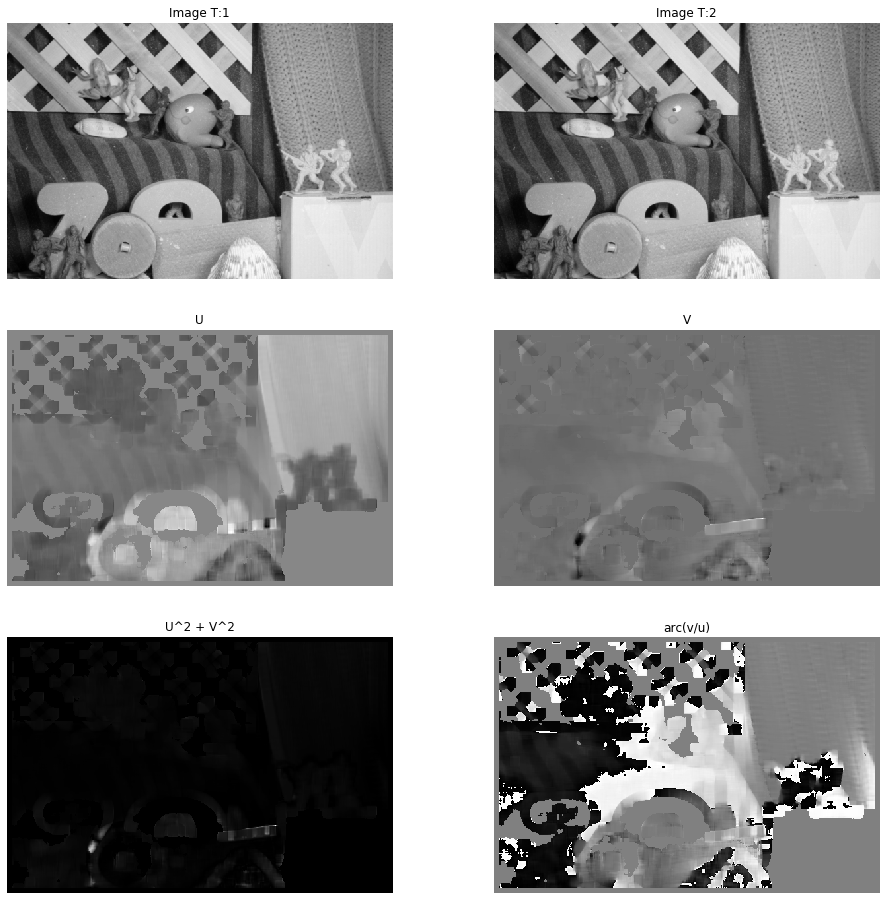

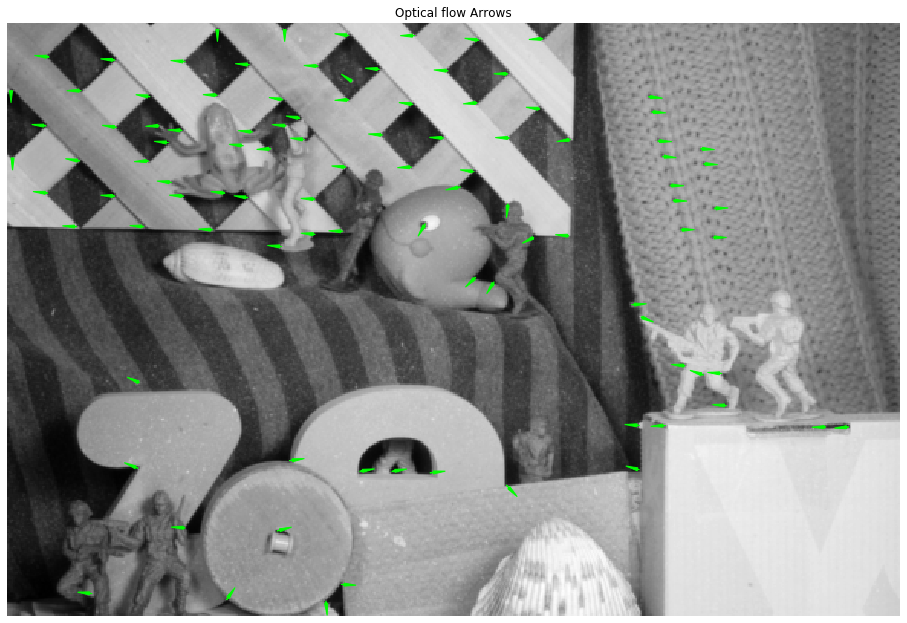

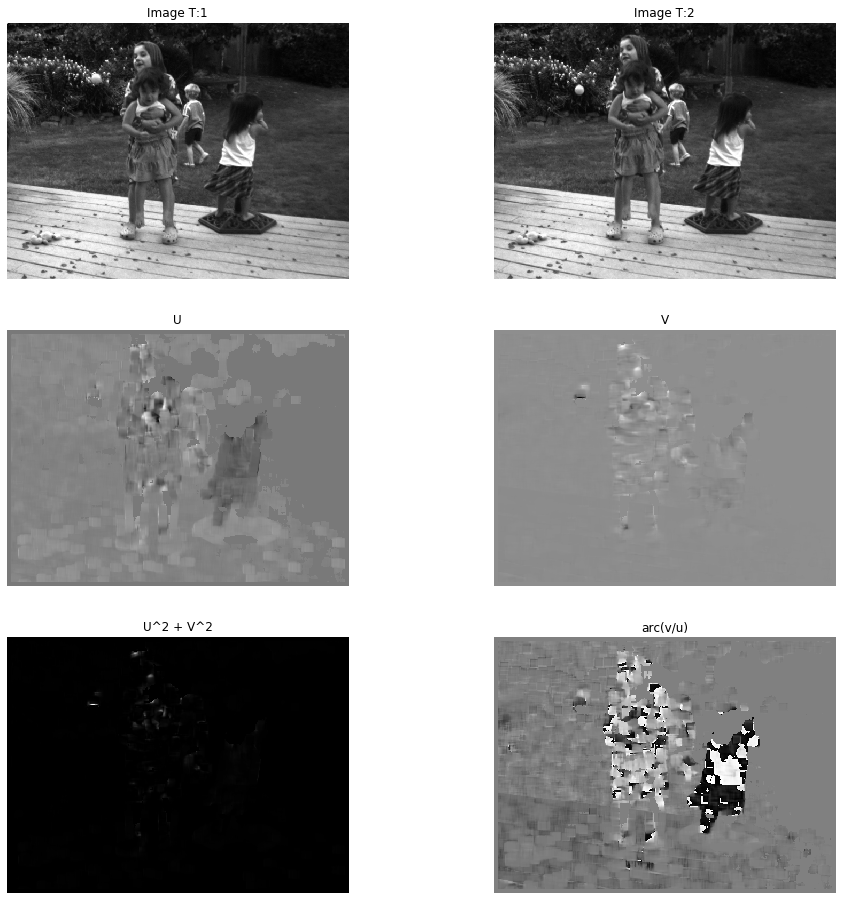

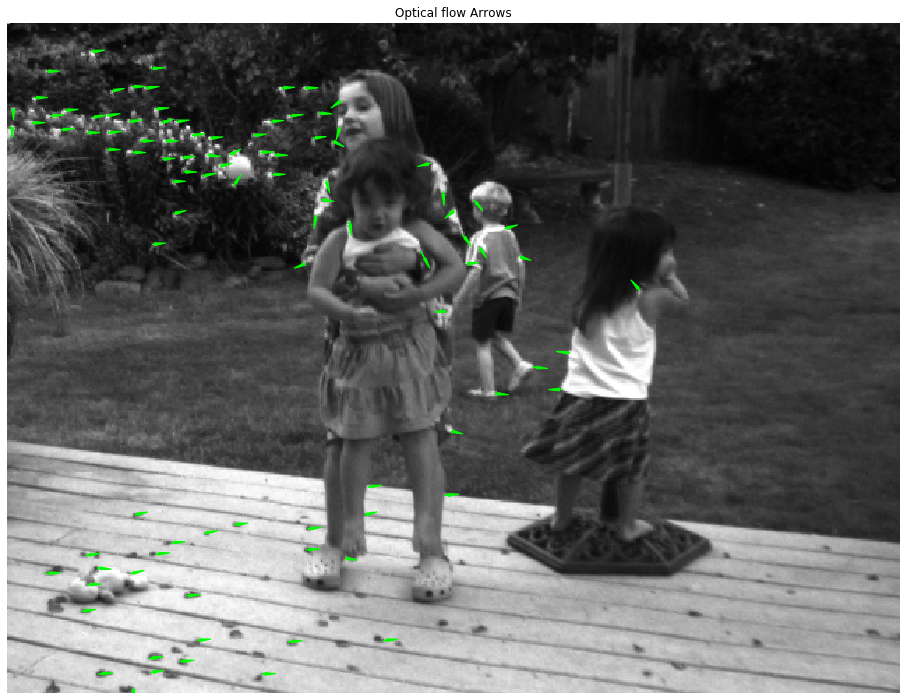

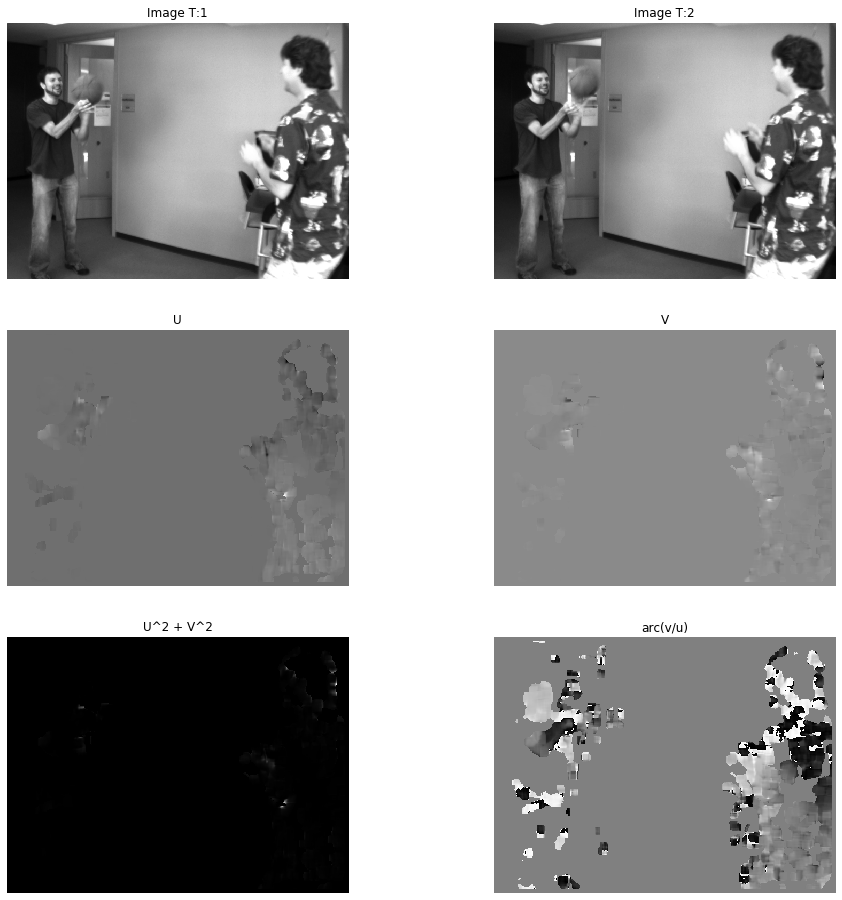

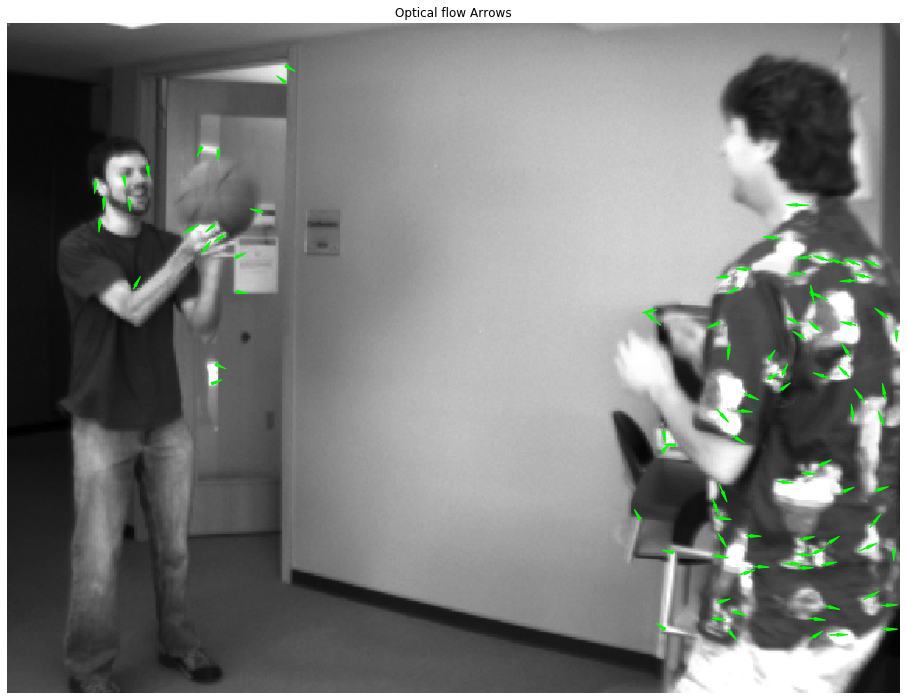

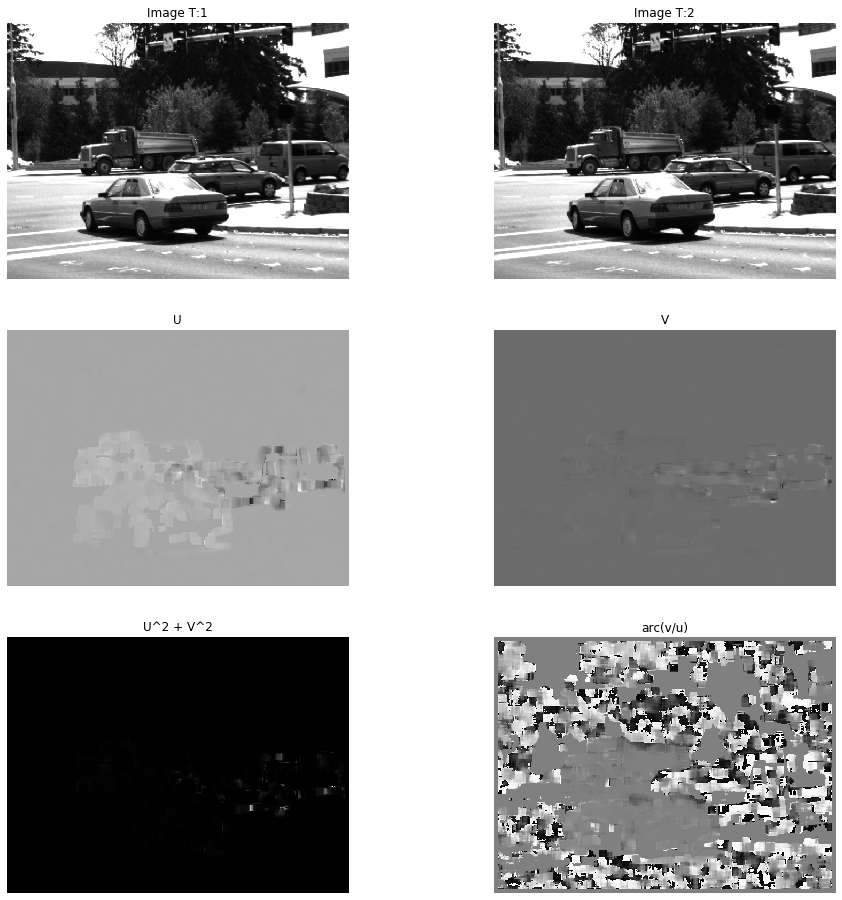

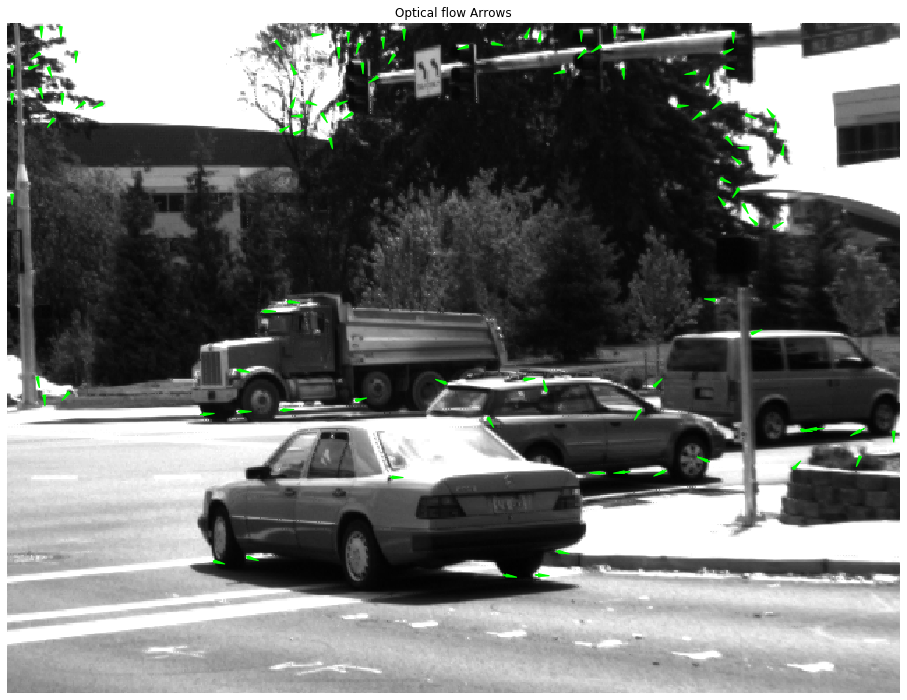

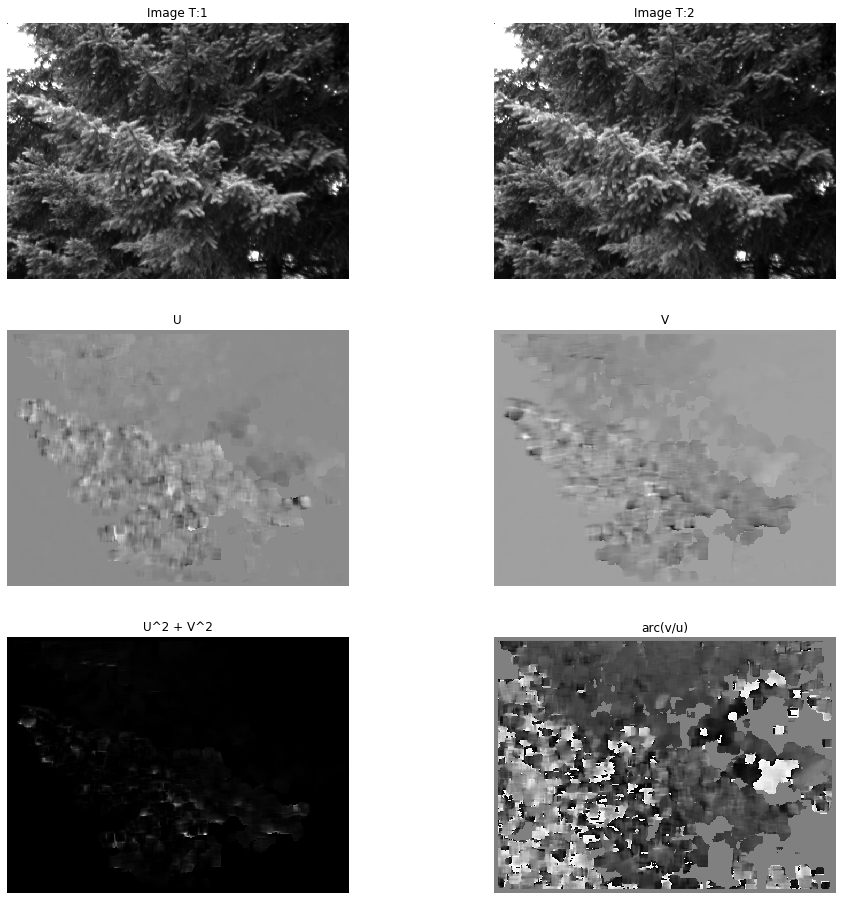

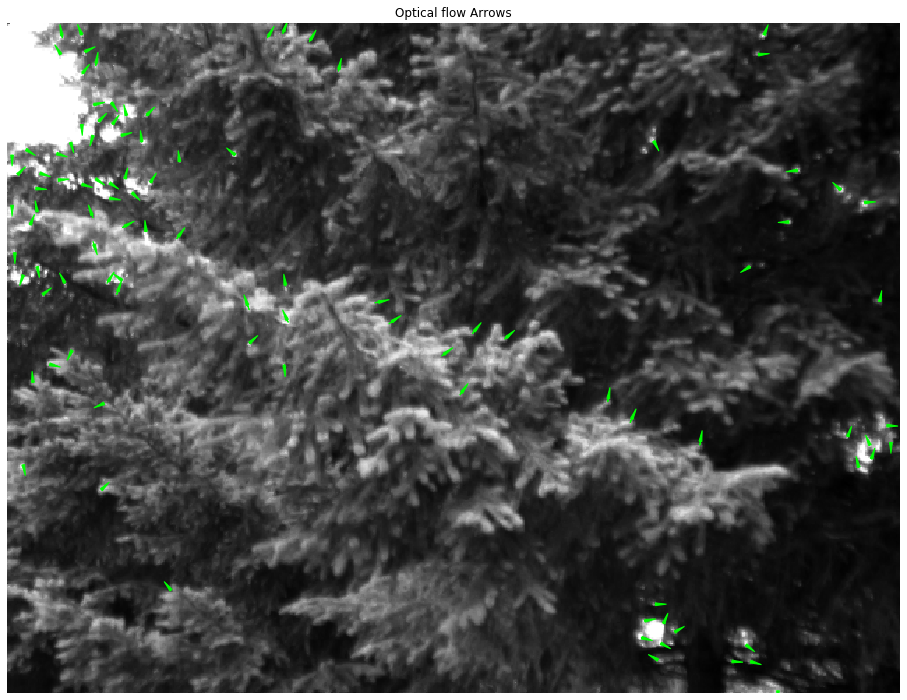

In [7]:
count = 0
for image_pair in img_pair_list:
    count +=1 
    if(count<=5):
        im1,im2 = image_pair
        u,v = optical_flow(im1,im2,window_size=15)
        display_opticalflow_results(im1,im2,u,v,arrow_thres=1)

In [ ]:
import numpy as np
import cv2
import os


def draw_hsv(u,v):
    (h, w) = u.shape[:2]
    (fx, fy) = (u, v)
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx * fx + fy * fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ang * (180 / np.pi / 2)
    hsv[..., 1] = 0xFF
    hsv[..., 2] = np.minimum(v * 4, 0xFF)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    #cv2.imshow('hsv', bgr)
    return bgr

def draw_flow(img, u, v, step=16):
    
    #from the beginning to position 2 (excluded channel info at position 3)
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = u[y,x], v[y,x]
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

frameRate = 0.1
input_dir = "output_data\\frames"
cap = cv2.VideoCapture('input_data/video.mp4')


# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
#p0 = cv2.goodFeaturesToTrack(old_gray, 100, 0.01, 10, 3)


count = 0
sec = 1

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    ret,frame = cap.read()
    vis = frame.copy()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    u,v = optical_flow(old_gray,frame_gray,window_size=31)
    #flowmap = compute_flow_map(u, v, old_gray)
    

    gray1 = cv2.cvtColor(draw_hsv(u,v), cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray1, 25, 0xFF, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)
    gray2, cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # loop over the contours
    for c in cnts:

        # if the contour is too small, ignore it
        (x, y, w, h) = cv2.boundingRect(c)
        if w > 200 and h > 200 and w < 1000 and h < 780:
            cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 0xFF, 0), 4)
                    
    cv2.imwrite(os.path.join(input_dir+'bbx/', "bbx"+str(count)+".jpg"), vis)
    cv2.imwrite(os.path.join(input_dir+'thr', "thr_"+str(count)+".jpg"), thresh)
    cv2.imwrite(os.path.join(input_dir+'flow', "image_"+str(count)+".jpg"), draw_flow(frame_gray, u, v))
       
    count+=1
    sec = sec + frameRate
    sec = round(sec, 2)
    old_gray = frame_gray.copy()

cv2.destroyAllWindows()
cap.release()

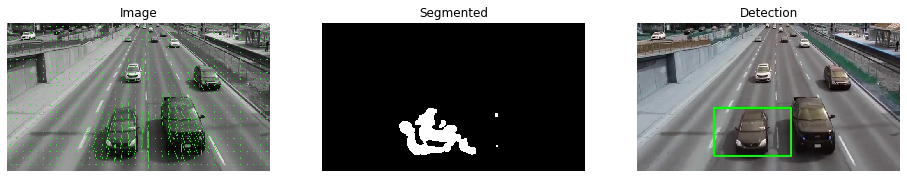

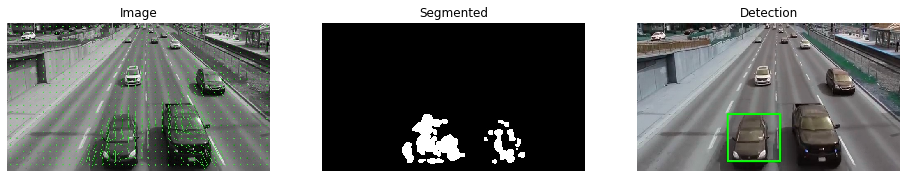

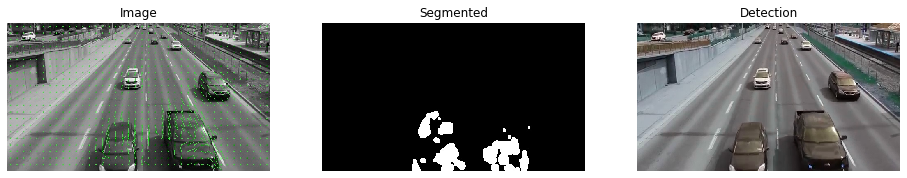

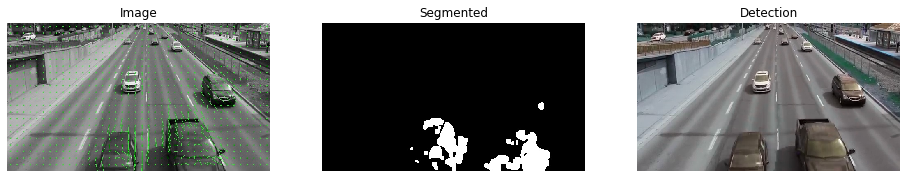

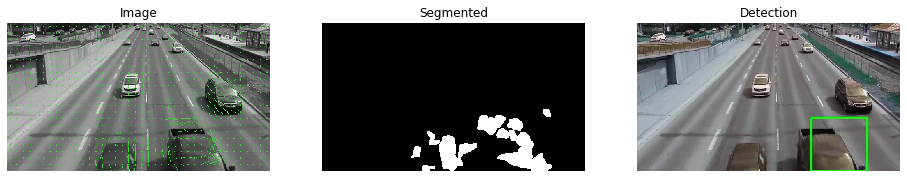

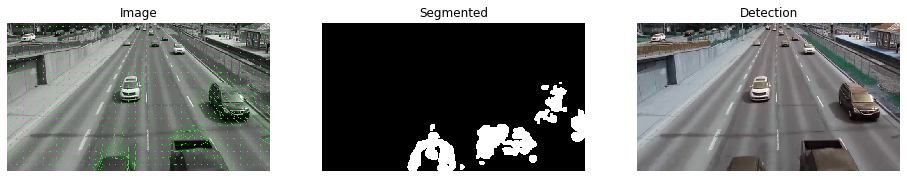

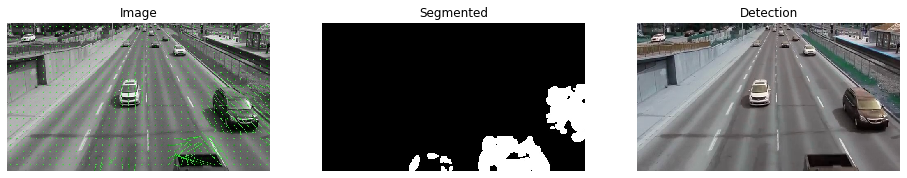

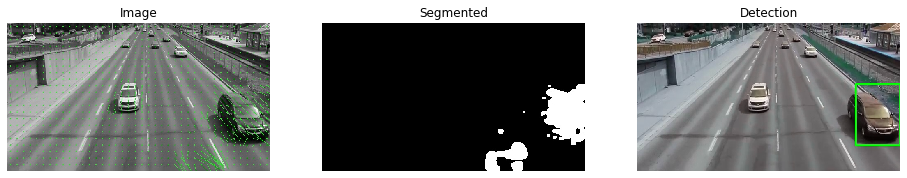

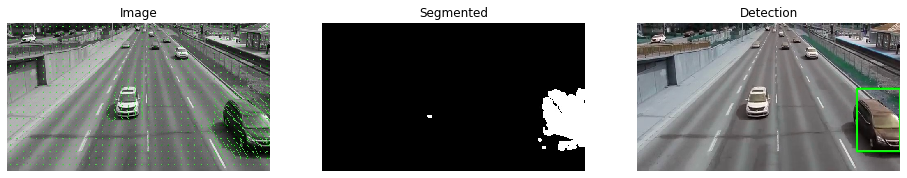

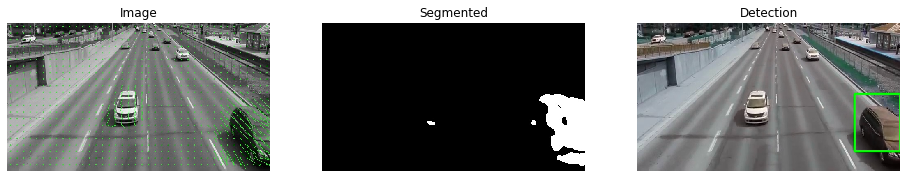

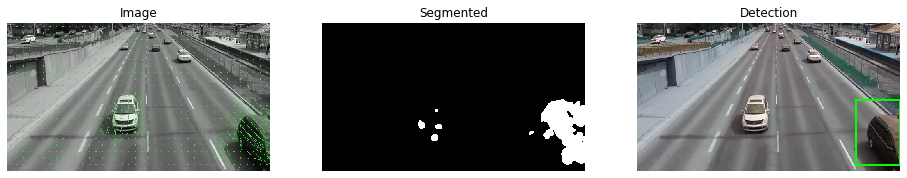

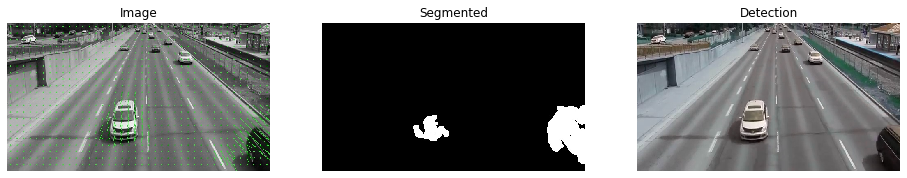

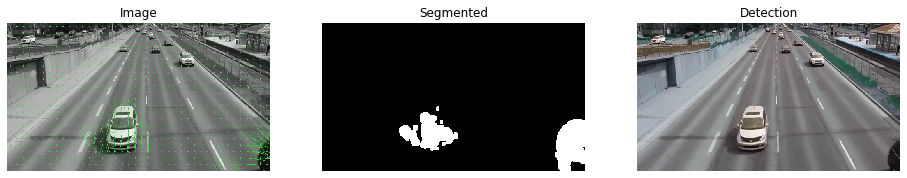

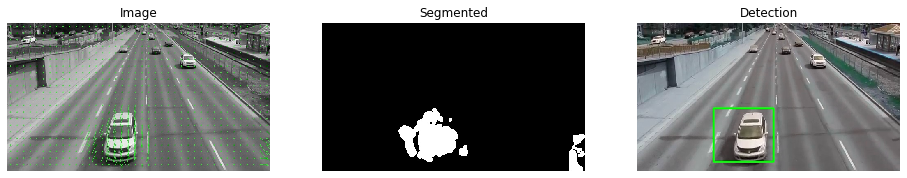

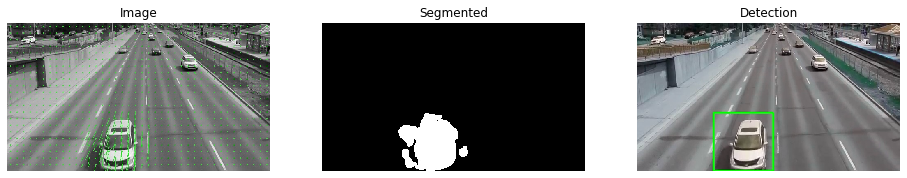

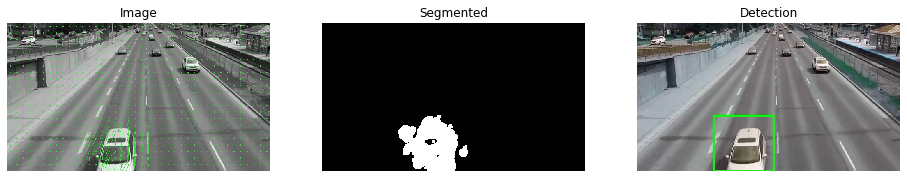

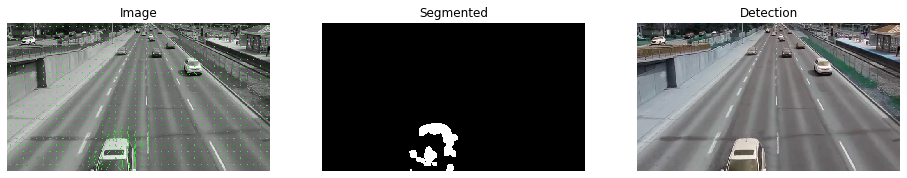

In [16]:
flow_path = "output_data\\flow\\"
thr_path = "output_data\\thr\\"
bbx_path = "output_data\\bbx\\"
img_array = []   
# Taking each image and forming array of images
for count in range(len(os.listdir(input_dir))):
    if(count > 153 and count < 171):
        image = flow_path+'image_'+str(count)+'.jpg'
        thr = thr_path+'thr_'+str(count)+'.jpg'
        bbx = bbx_path+'bbx_'+str(count)+'.jpg'
        
        img1 = cv.imread(image) 
        img2 = cv.imread(thr) 
        img3 = cv.imread(bbx) 
        
        fig_size=(16,16)
        fig = plt.figure(figsize=fig_size)
    
        #     Images
        ax = fig.add_subplot(3,3,1)
        ax.imshow(img1,cmap='gray')
        ax.set_title("Image")
        ax.axis('off')
        
        ax = fig.add_subplot(3,3,2)
        ax.imshow(img2)
        ax.set_title("Segmented")
        ax.axis('off')
        
        ax = fig.add_subplot(3,3,3)
        ax.imshow(img3,cmap='gray')
        ax.set_title("Detection")
        ax.axis('off')
        
        plt.show()